# Kinetic Component Analysis in Julia
#### Own R code translated from the Python code found in Kinetic Component Analysis, Marcos López de Prado & Riccardo Rebonato - Journal of Investing (2016). and only changed slightly to allow for user input with regarding to the size of A (i.e. the number of degrees of the Taylor expansion).

In [5]:
if (!require("dlm")) install.packages("dlm")
require("dlm")

Loading required package: dlm

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘dlm’”
Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)

Loading required package: dlm



In [6]:
getPeriodic <- function(periods = 10, nobs = 300, scale = 0.5) {
  x <- seq(from = 0, to = pi*periods*2, length = nobs)
  s <- sin(x)
  z <- s + rnorm(n = nobs, mean = 0, sd = scale)
  return (list(x=x, s=s, z=z))
}

In [7]:
fitKCA <- function(x, z, q = 0.001, a = 2) {
  require(dlm)
  # 1) Set up matrices A, H, and Q
  N <- length(x)
  h <- (x[N] - x[1])/N
  H <- matrix(0, 1, a + 1) ; H[1, 1] <- 1
  A <- matrix(0, a + 1, a + 1)
  for (i in 1:(a + 1)) {
    tmp <- diag(a - i + 2) / factorial(i - 1) * h^(i - 1)
    A[1:(a - i + 2), i:(a + 1)] <- A[1:(a - i + 2), i:(a + 1)] + tmp
  }
  #Q <- diag(a + 1) * q
  
  # 2) Apply filter, MLE estimates and smoothing
  getMLE <- function(x) {
    V <- exp(x[1])
    W <- exp(x[2]) * diag(a + 1)
    m0 <- rep(0, a + 1)
    C0 <- diag(1e7, a + 1)
    return(list(m0 = m0, C0 = C0, FF = H, GG = A, V = V, W = W))
  }
  MLE <- dlmMLE(y = z, parm = c(0, 2), build = getMLE)
  kf <- dlm(FF = H, V = exp(MLE$par[1]), GG = A,
            W = diag(a + 1)*exp(MLE$par[2]), m0 = rep(0, a + 1), C0 = diag(a + 1))
  kf <- dlmFilter(y = z, mod = kf)
  kf <- dlmSmooth(kf)
  
  x_mean <- kf$s
  
  # 3) Std series
  x_std   <- matrix(0, N, a + 1)
  x_covar <- dlmSvd2var(u = kf$U.S, d = kf$D.S)
  for (n in 1:N) x_std[n, ] <- diag(x_covar[[n+1]])
  
  return (list(x_mean = x_mean, x_std = x_std, x_covar = x_covar))
}

In [8]:
plotKCA <- function(nobs = 300L, periods = 10L, scale = 0.5, q = 0.001, a = 2L) {
  if (!is.integer(nobs)) stop("Input 'nobs' must be an integer.")
  if (!is.integer(periods)) stop("Input 'periods' must be an integer.")
  if (!is.integer(a)) stop("Input 'a' must be an integer.")
  if (a < 0 || a > 6) stop("Input 'a' must be in [0; 6].")
  
  dat <- getPeriodic(periods, nobs, scale)
  x <- dat$x ; s <- dat$s ; z <- dat$z
  
  out <- fitKCA(x = x, z = z, q = q, a = a)
  x_mean <- as.matrix(out$x_mean)[-1, , drop = FALSE]
  x_std  <- as.matrix(out$x_std)
  cols <- c("blue", "green", "red", "pink", "yellow", "brown", "purple")
  degs <- c("Position", "Velocity", "Acceleration", "Jerk", "Snap", "Crackle", "Pop")
  plot(x, z, pch = 4)
  for (i in 1:(a + 1)) {
    lines(x, x_mean[, i], col = cols[i], lwd = 3)
    lines(x, x_mean[, i] + 2*x_std[, i], col = cols[i], lwd = 1)
    lines(x, x_mean[, i] - 2*x_std[, i], col = cols[i], lwd = 1)
  }
  legend("bottomleft", legend = degs[1:(a+1)], fill = cols[1:(a+1)])
  
}

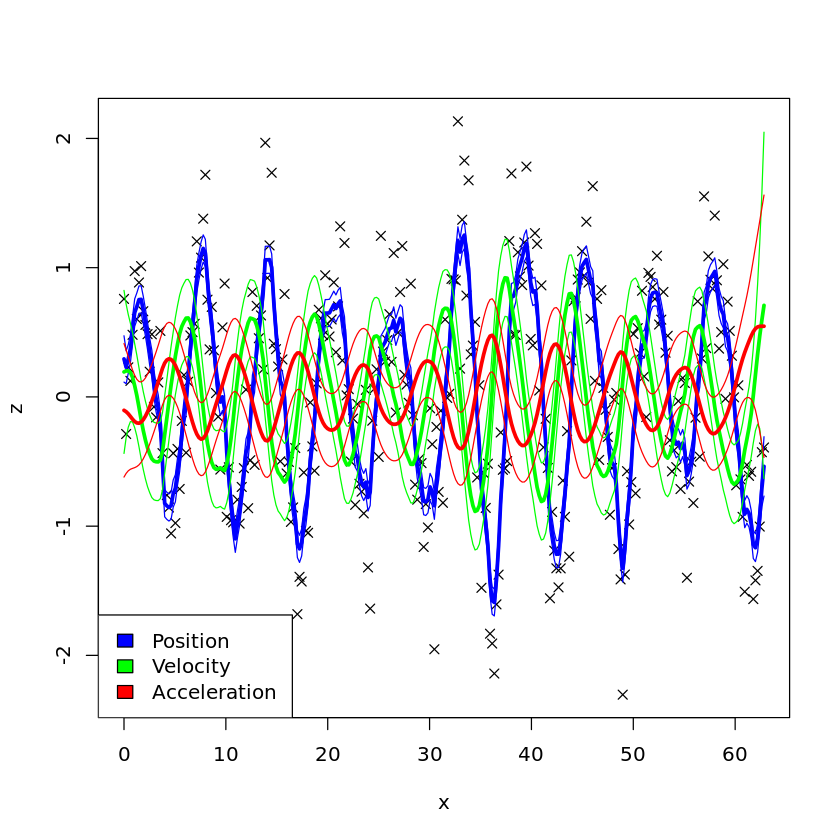

In [9]:
plotKCA()